In [1]:
#librerie
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from google.colab import drive
from scipy import integrate
from time import sleep
from scipy.optimize import curve_fit
from scipy.signal import find_peaks_cwt

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_to_file="drive/MyDrive/Lab HPGE/Data/Ge/Ba133/THR_500__GAIN_30/Ge_Ba133_500_g30_7.xml"  #change this 



tree = ET.parse(path_to_file) 
root=tree.getroot()

In [5]:
list=[]

#output of the code below: a list of events and each event is a list of 8192 samples  

for event in root.findall("event"):  #this finds all the event in the file
    string_event=event.find("trace").text  #this takes all the samples for each event
    int_event=[int(string_number) for string_number in string_event.split()] #splitting and casting to int
    list.append(int_event)
    #if(len(list)>15000):
    #   break         

In [6]:
sample_space=10e-9 #10 ns
samples_per_event=len(list[0]) # 8192

evento=75 #pick an event to plot below

time_axis=np.linspace(sample_space,samples_per_event*sample_space,samples_per_event)  # from 10 ns to 8192*10 ns 
samples_axis=np.linspace(1,len(list[evento]),num=len(list[evento])) # from 1 to 8192

In [7]:
list_event=np.array(list) # casting to a numpy array

Saturation problem below


In [8]:
saturation_point=16383 #limit points saturation

#find the maximum of each event
maxima_peaks=np.zeros(len(list))
list_event.max(axis=1,out=maxima_peaks)

#find the index of each event that has a saturation problem
index_saturated=[i for i in range(len(maxima_peaks)) if(maxima_peaks[i]==saturation_point)]

print("There are ",len(index_saturated), "saturated events in this run.")

There are  181 saturated events in this run.


In [9]:
print(index_saturated)
#maxima_5=np.where(list_event[5]==saturation_point)
#print(len(maxima_5[0]))

maxima=[]
for i in range(len(list_event)):
    maxima.append(np.where(list_event[i]==saturation_point))

print(len(maxima[8][0]))


[136, 208, 283, 301, 555, 673, 705, 840, 1043, 1047, 1252, 1457, 1736, 1872, 1978, 2194, 2214, 2223, 2230, 2588, 2594, 2677, 2687, 2732, 2744, 2775, 3191, 3511, 3600, 3715, 4073, 4248, 4446, 4458, 4553, 5155, 5205, 5475, 5552, 5688, 5935, 6047, 6070, 6258, 6412, 6457, 6591, 6903, 7190, 7279, 7450, 7566, 7621, 7835, 8065, 8135, 8639, 9113, 9312, 9530, 9606, 9730, 9997, 10192, 10700, 10706, 11112, 11238, 11306, 11311, 11487, 11582, 11634, 11755, 11862, 11948, 11951, 11956, 12183, 12316, 12357, 12734, 12934, 13093, 13099, 13332, 13558, 13731, 13802, 13853, 14180, 14223, 14371, 14442, 14560, 14738, 14903, 15113, 15196, 15211, 15218, 15282, 15311, 15409, 15580, 15633, 15697, 15788, 16005, 16024, 16072, 16232, 16489, 16694, 17012, 17051, 17080, 17226, 17265, 17341, 17468, 17912, 18189, 18210, 18336, 18351, 18397, 18763, 19019, 19149, 19228, 19233, 19241, 19259, 19549, 19629, 19932, 19968, 20018, 20037, 20394, 20399, 20916, 21051, 21052, 21133, 21317, 21377, 21382, 21445, 21457, 21874, 22030,

In [10]:
mini_sat=[]
mini_sat_700=[]
for i in range(len(list_event)):
    if(len(maxima[i][0])<1200 and len(maxima[i][0])>1000):
        mini_sat.append(i)
print(mini_sat)
print(len(mini_sat))

[2194, 2594, 2677, 3715, 4248, 6591, 7566, 9312, 9997, 12316, 15311, 15697, 16232, 20394, 21052, 21377, 23500]
17


In [11]:
def gaussian(x, N, mu,sigma):
    return N * np.exp(-0.5*((x-mu)/sigma)**2)

flag=1 #if 0 the saturated events will be overwritten in the same array, otherwise saturated events will be filled 

threshold_value=50 #select a portion of the event that has a signal discarding samples below the threshold level
saturated_events_fitted=np.zeros((len(list_event),len(list_event[0]))) 

cupola = np.zeros((len(list_event),len(list_event[0])))
cupola1=[]

index_problematic=[]
i=0
index=[]
for index_event in index_saturated: #cycle on saturated events
    event=list_event[index_event] #select the event 
    sx=[]
    dx=[]
    graph_sx=[]
    graph_dx=[]
    small_points_dx=[]
    small_points_sx=[]
    plateau_points=[]

    plateau_points=[i for i in range(len(event)) if(event[i]==saturation_point)] #range of x_points where the plateau is located

    len_Plateau=len(plateau_points)

    
    #             _________________
    #            /|               |\
    #           / |               | \
    # ---------/---------------------\-------------------
    #_________/   |               |   \______________
    #         |   |    plateau    |   |
    #         |   |               |   |
    # small   |   |___            |   |_     small points
    # points  | graph |           |graph|       dx
    #  sx     |   sx  |           | dx  |
    #
    #

    small_points_sx=[i for i in range(len(event)) if(event[i]<threshold_value and i<plateau_points[0])]
    sx=[i for i in range(plateau_points[0]) if(event[i]>=threshold_value and event[i]<saturation_point)]
    dx=[i for i in range(plateau_points[0],len(event)) if(event[i]>=threshold_value and event[i]<saturation_point)]
    graph_sx=[event[i] for i in range(plateau_points[0]) if(event[i]>=threshold_value and event[i]<saturation_point)]
    graph_dx=[event[i] for i in range(plateau_points[0],len(event)) if(event[i]>=threshold_value and event[i]<saturation_point)]
    small_points_dx=[i for i in range(len(event)) if(event[i]<threshold_value and i>plateau_points[0])]

    #filling the right arrays
    x_graph=np.zeros(len(sx)+len(dx))
    np.concatenate((sx,dx),out=x_graph)
    graph=np.zeros(len(graph_sx)+len(graph_dx))
    np.concatenate((graph_sx,graph_dx),out=graph)
    sinistra =[0]*len(small_points_sx)
    destra = [0]*len(small_points_dx)
    #fitting 
    try:
        init_vals = [saturation_point,plateau_points[int(len(plateau_points)/2)] ,len(plateau_points)]  # for [N,mu, wid]
        best_vals, covar = curve_fit(gaussian, x_graph, graph,p0=init_vals) 
    except:
        index_problematic.append(index_event)
    #print(len(sinistra)+len(graph_sx)+len(gaussian_event[(plateau_points[0]):(plateau_points[-1])])+len(graph_dx)+len(destra))
    gaussian_event=gaussian(samples_axis,best_vals[0],best_vals[1],best_vals[2])
    cupola1.append(np.concatenate((sinistra,graph_sx,gaussian_event[plateau_points],graph_dx,destra)))
    
    int_val=integrate.trapz(cupola1[i],time_axis)
    i+=1
    if int_val>1.6 and int_val<1.75:
        index.append(index_event)
        saturated_events_fitted[index_event]=cupola1[-1]
    
    #cupola[index_event]=np.array(cupola1[])

    #print(len(cupola))
#    if(index_event==6):
#        plt.plot(samples_axis,gaussian(samples_axis,best_vals[0],best_vals[1],best_vals[2]))
#        plt.plot(x_graph,graph,ls="",marker=".")

    #filling the final array:
    if(flag==0):
        list_event[index_event]=gaussian_event
    else:
        saturated_events_fitted[index_event]=cupola1[-1]



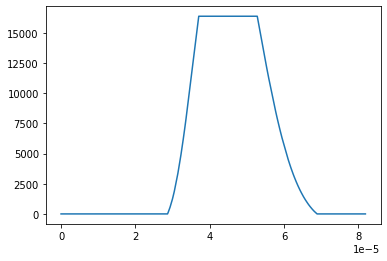

In [12]:
plt.plot(time_axis,list_event[index_saturated[0]])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path_to_plots="/content/drive/MyDrive/Lab HPGE/Data/Plots/"  
plt.savefig(path_to_plots+"NAI_waveform.png")

<Figure size 432x288 with 0 Axes>

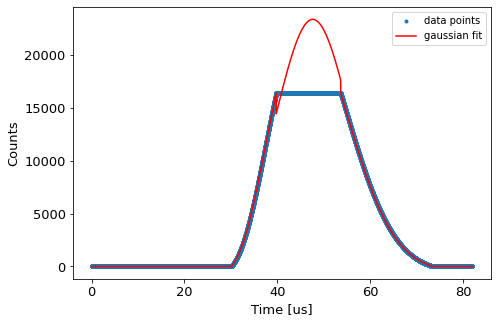

In [ ]:
plt.figure(figsize=(7.5,5))
numb_event=index_saturated[16]
plt.plot(time_axis*1000000,list_event[numb_event],ls="",marker=".",label="data points")
plt.plot(time_axis*1000000,saturated_events_fitted[numb_event],label="gaussian fit",color="red")

plt.xlabel("Time [us]",fontsize=13)
plt.ylabel("Counts",fontsize=13)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.legend()


path_to_plots="/content/drive/MyDrive/Lab HPGE/Data/Plots/"  
plt.savefig(path_to_plots+"Gauss_sat_fit.png")

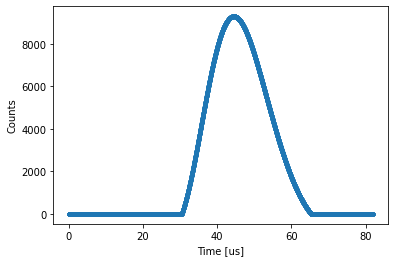

In [ ]:
numb_event=5
plt.plot(time_axis*1000000,list_event[numb_event],ls="",marker=".")
plt.xlabel("Time [us]")
plt.ylabel("Counts")

path_to_plots="/content/drive/MyDrive/Lab HPGE/Data/Plots/"  
plt.savefig(path_to_plots+"Gauss_nonsat_fit.png")

#plt.plot(samples_axis,list_event[numb_event],ls="",marker=".")
#plt.plot(samples_axis,saturated_events_fitted[numb_event])

In [ ]:
non_saturated_events = np.delete(list_event,index_saturated,axis=0)

In [ ]:
non_sat_values_integrals=[integrate.trapz(event,time_axis) for event in non_saturated_events] #evaluating the spectrum
sat_values_integrals=[integrate.trapz(event,time_axis) for event in cupola1]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


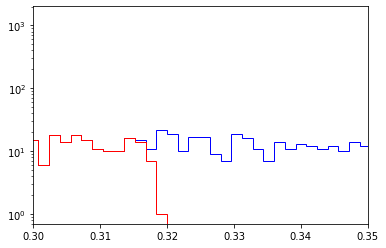

In [ ]:
numb_bins=500

plt.hist((non_sat_values_integrals,sat_values_integrals),bins=numb_bins,histtype="step",color=("red","blue"),range=(0.0,0.8),stacked=True)
#plt.hist(sat_values_integrals,bins=numb_bins,histtype="step",color="blue",range=(0.0,0.8),stacked=True)
plt.xlim(0.3,0.35)
plt.yscale("log")
plt.show()

In [ ]:
values_integrals=[integrate.trapz(event,time_axis) for event in list_event] #evaluating the spectrum

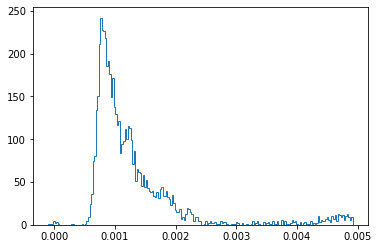

In [ ]:
#histogram of the spectrum
numb_bins=200  #try to change this maybe

plt.hist(values_integrals,bins=numb_bins,histtype="step")
#plt.ylim(0,200)   #to cut the y axis 
#plt.xlim(0.65,0.9)
plt.show()


In [ ]:
len(list_event)

5590